# Twitter Sentiment Analysis

Hate Speech in the form of racism and sexism has become a nuisance on twitter and 
it is important to segregate these sort of tweets from the rest.
We provide Twitter data that has both normal and hate tweets. 
Your task as a Data Scientist is to identify the tweets which are hate tweets and which are not.


In [1]:
# Importing Libraries 
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
# Files available in our data sets
import os
print(os.listdir("Dataset"))

['train_tweets.csv', 'test_tweets.csv']


In [3]:
# Loading Data
train_df = pd.read_csv("Dataset/train_tweets.csv")
test_df = pd.read_csv("Dataset/test_tweets.csv")

In [4]:
#Training Data Set
train_df.head(10)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
5,6,0,[2/2] huge fan fare and big talking before the...
6,7,0,@user camping tomorrow @user @user @user @use...
7,8,0,the next school year is the year for exams.ð...
8,9,0,we won!!! love the land!!! #allin #cavs #champ...
9,10,0,@user @user welcome here ! i'm it's so #gr...


In [5]:
#Testing Data Set
test_df.head()
print('Testing data set has no Label column')
print(test_df.head(10))

Testing data set has no Label column
      id                                              tweet
0  31963  #studiolife #aislife #requires #passion #dedic...
1  31964   @user #white #supremacists want everyone to s...
2  31965  safe ways to heal your #acne!!    #altwaystohe...
3  31966  is the hp and the cursed child book up for res...
4  31967    3rd #bihday to my amazing, hilarious #nephew...
5  31968                        choose to be   :) #momtips 
6  31969  something inside me dies ð¦ð¿â¨  eyes nes...
7  31970  #finished#tattoo#inked#ink#loveitâ¤ï¸ #â¤ï¸...
8  31971   @user @user @user i will never understand why...
9  31972  #delicious   #food #lovelife #capetown mannaep...


In [6]:
# Training Data Set Information
print("Training Data Set Info - Total Rows | Total Columns | Total Null Values")
print(train_df.info())

Training Data Set Info - Total Rows | Total Columns | Total Null Values
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
id       31962 non-null int64
label    31962 non-null int64
tweet    31962 non-null object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB
None


In [7]:
# Testing Data Set Information
print("Test Data Set Info - Total Rows | Total Columns | Total Null Values")
print(test_df.info())

Test Data Set Info - Total Rows | Total Columns | Total Null Values
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17197 entries, 0 to 17196
Data columns (total 2 columns):
id       17197 non-null int64
tweet    17197 non-null object
dtypes: int64(1), object(1)
memory usage: 268.8+ KB
None


In [8]:
# Merging both the data sets as tweets in both the data set is unstructured
combine_df = train_df.append(test_df, ignore_index = True, sort = False)
combine_df.head()

,id,label,tweet
0,1,0.0,@user when a father is dysfunctional and is s...
1,2,0.0,@user @user thanks for #lyft credit i can't us...
2,3,0.0,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...
4,5,0.0,factsguide: society now #motivation


In [9]:
# Combine (Merged) Data Set Information
print("Combine Data Set Info - Total Rows | Total Columns | Total Null Values")
print(combine_df.info())

Combine Data Set Info - Total Rows | Total Columns | Total Null Values
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49159 entries, 0 to 49158
Data columns (total 3 columns):
id       49159 non-null int64
label    31962 non-null float64
tweet    49159 non-null object
dtypes: float64(1), int64(1), object(1)
memory usage: 1.1+ MB
None


### Step A : Converting html entities

In [10]:
print("""Step A : Converting html entities i.e. (&lt; &gt; &amp;)
( "&lt;" is converted to “<” and "&amp;" is converted to “&”)""")

Step A : Converting html entities i.e. (&lt; &gt; &amp;)
( "&lt;" is converted to “<” and "&amp;" is converted to “&”)


In [11]:
# Importing HTMLParser
from html.parser import HTMLParser
html_parser = HTMLParser()


In [12]:
# Created a new columns i.e. clean_tweet contains the same tweets but cleaned version
combine_df['clean_tweet'] = combine_df['tweet'].apply(lambda x: html_parser.unescape(x))
combine_df.head(10)

,id,label,tweet,clean_tweet
0,1,0.0,@user when a father is dysfunctional and is s...,@user when a father is dysfunctional and is s...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,@user @user thanks for #lyft credit i can't us...
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...
4,5,0.0,factsguide: society now #motivation,factsguide: society now #motivation
5,6,0.0,[2/2] huge fan fare and big talking before the...,[2/2] huge fan fare and big talking before the...
6,7,0.0,@user camping tomorrow @user @user @user @use...,@user camping tomorrow @user @user @user @use...
7,8,0.0,the next school year is the year for exams.ð...,the next school year is the year for exams.ð...
8,9,0.0,we won!!! love the land!!! #allin #cavs #champ...,we won!!! love the land!!! #allin #cavs #champ...
9,10,0.0,@user @user welcome here ! i'm it's so #gr...,@user @user welcome here ! i'm it's so #gr...


### Step B : Removing "@user" from all the tweets

In [13]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt

In [14]:
# remove twitter handles (@user)
combine_df['clean_tweet'] = np.vectorize(remove_pattern)(combine_df['clean_tweet'], "@[\w]*")
combine_df.head(10)

,id,label,tweet,clean_tweet
0,1,0.0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so sel...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i can't use cause th...
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...
4,5,0.0,factsguide: society now #motivation,factsguide: society now #motivation
5,6,0.0,[2/2] huge fan fare and big talking before the...,[2/2] huge fan fare and big talking before the...
6,7,0.0,@user camping tomorrow @user @user @user @use...,camping tomorrow dannyâ¦
7,8,0.0,the next school year is the year for exams.ð...,the next school year is the year for exams.ð...
8,9,0.0,we won!!! love the land!!! #allin #cavs #champ...,we won!!! love the land!!! #allin #cavs #champ...
9,10,0.0,@user @user welcome here ! i'm it's so #gr...,welcome here ! i'm it's so #gr8 !


### Step C : Changing all the tweets into lowercase

In [15]:
combine_df['clean_tweet'] = combine_df['clean_tweet'].apply(lambda x: x.lower())
combine_df.head(10)

,id,label,tweet,clean_tweet
0,1,0.0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so sel...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i can't use cause th...
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...
4,5,0.0,factsguide: society now #motivation,factsguide: society now #motivation
5,6,0.0,[2/2] huge fan fare and big talking before the...,[2/2] huge fan fare and big talking before the...
6,7,0.0,@user camping tomorrow @user @user @user @use...,camping tomorrow dannyâ¦
7,8,0.0,the next school year is the year for exams.ð...,the next school year is the year for exams.ð...
8,9,0.0,we won!!! love the land!!! #allin #cavs #champ...,we won!!! love the land!!! #allin #cavs #champ...
9,10,0.0,@user @user welcome here ! i'm it's so #gr...,welcome here ! i'm it's so #gr8 !


### Step D : Apostrophe Lookup

In [16]:
# Apostrophe Dictionary
apostrophe_dict = {
"ain't": "am not / are not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is",
"i'd": "I had / I would",
"i'd've": "I would have",
"i'll": "I shall / I will",
"i'll've": "I shall have / I will have",
"i'm": "I am",
"i've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}
apostrophe_dict

{"ain't": 'am not / are not',
 "aren't": 'are not / am not',
 "can't": 'cannot',
 "can't've": 'cannot have',
 "'cause": 'because',
 "could've": 'could have',
 "couldn't": 'could not',
 "couldn't've": 'could not have',
 "didn't": 'did not',
 "doesn't": 'does not',
 "don't": 'do not',
 "hadn't": 'had not',
 "hadn't've": 'had not have',
 "hasn't": 'has not',
 "haven't": 'have not',
 "he'd": 'he had / he would',
 "he'd've": 'he would have',
 "he'll": 'he shall / he will',
 "he'll've": 'he shall have / he will have',
 "he's": 'he has / he is',
 "how'd": 'how did',
 "how'd'y": 'how do you',
 "how'll": 'how will',
 "how's": 'how has / how is',
 "i'd": 'I had / I would',
 "i'd've": 'I would have',
 "i'll": 'I shall / I will',
 "i'll've": 'I shall have / I will have',
 "i'm": 'I am',
 "i've": 'I have',
 "isn't": 'is not',
 "it'd": 'it had / it would',
 "it'd've": 'it would have',
 "it'll": 'it shall / it will',
 "it'll've": 'it shall have / it will have',
 "it's": 'it has / it is',
 "let's": 'l

In [17]:
def lookup_dict(text, dictionary):
    for word in text.split():
        if word.lower() in dictionary:
            if word.lower() in text.split():
                text = text.replace(word, dictionary[word.lower()])
    return text

In [18]:
combine_df['clean_tweet'] = combine_df['clean_tweet'].apply(lambda x: lookup_dict(x,apostrophe_dict))
combine_df.head(10)

,id,label,tweet,clean_tweet
0,1,0.0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so sel...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i cannot use cause t...
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...
4,5,0.0,factsguide: society now #motivation,factsguide: society now #motivation
5,6,0.0,[2/2] huge fan fare and big talking before the...,[2/2] huge fan fare and big talking before the...
6,7,0.0,@user camping tomorrow @user @user @user @use...,camping tomorrow dannyâ¦
7,8,0.0,the next school year is the year for exams.ð...,the next school year is the year for exams.ð...
8,9,0.0,we won!!! love the land!!! #allin #cavs #champ...,we won!!! love the land!!! #allin #cavs #champ...
9,10,0.0,@user @user welcome here ! i'm it's so #gr...,welcome here ! I am it has / it is so #g...


### Step E : Short Word Lookup

In [19]:
short_word_dict = {
"121": "one to one",
"a/s/l": "age, sex, location",
"adn": "any day now",
"afaik": "as far as I know",
"afk": "away from keyboard",
"aight": "alright",
"alol": "actually laughing out loud",
"b4": "before",
"b4n": "bye for now",
"bak": "back at the keyboard",
"bf": "boyfriend",
"bff": "best friends forever",
"bfn": "bye for now",
"bg": "big grin",
"bta": "but then again",
"btw": "by the way",
"cid": "crying in disgrace",
"cnp": "continued in my next post",
"cp": "chat post",
"cu": "see you",
"cul": "see you later",
"cul8r": "see you later",
"cya": "bye",
"cyo": "see you online",
"dbau": "doing business as usual",
"fud": "fear, uncertainty, and doubt",
"fwiw": "for what it's worth",
"fyi": "for your information",
"g": "grin",
"g2g": "got to go",
"ga": "go ahead",
"gal": "get a life",
"gf": "girlfriend",
"gfn": "gone for now",
"gmbo": "giggling my butt off",
"gmta": "great minds think alike",
"h8": "hate",
"hagn": "have a good night",
"hdop": "help delete online predators",
"hhis": "hanging head in shame",
"iac": "in any case",
"ianal": "I am not a lawyer",
"ic": "I see",
"idk": "I don't know",
"imao": "in my arrogant opinion",
"imnsho": "in my not so humble opinion",
"imo": "in my opinion",
"iow": "in other words",
"ipn": "I’m posting naked",
"irl": "in real life",
"jk": "just kidding",
"l8r": "later",
"ld": "later, dude",
"ldr": "long distance relationship",
"llta": "lots and lots of thunderous applause",
"lmao": "laugh my ass off",
"lmirl": "let's meet in real life",
"lol": "laugh out loud",
"ltr": "longterm relationship",
"lulab": "love you like a brother",
"lulas": "love you like a sister",
"luv": "love",
"m/f": "male or female",
"m8": "mate",
"milf": "mother I would like to fuck",
"oll": "online love",
"omg": "oh my god",
"otoh": "on the other hand",
"pir": "parent in room",
"ppl": "people",
"r": "are",
"rofl": "roll on the floor laughing",
"rpg": "role playing games",
"ru": "are you",
"shid": "slaps head in disgust",
"somy": "sick of me yet",
"sot": "short of time",
"thanx": "thanks",
"thx": "thanks",
"ttyl": "talk to you later",
"u": "you",
"ur": "you are",
"uw": "you’re welcome",
"wb": "welcome back",
"wfm": "works for me",
"wibni": "wouldn't it be nice if",
"wtf": "what the fuck",
"wtg": "way to go",
"wtgp": "want to go private",
"ym": "young man",
"gr8": "great"
}

In [20]:
combine_df['clean_tweet'] = combine_df['clean_tweet'].apply(lambda x: lookup_dict(x,short_word_dict))
combine_df.head(10)

,id,label,tweet,clean_tweet
0,1,0.0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so sel...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i cannot use cause t...
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...,#model i love you take with you all the time...
4,5,0.0,factsguide: society now #motivation,factsguide: society now #motivation
5,6,0.0,[2/2] huge fan fare and big talking before the...,[2/2] huge fan fare and big talking before the...
6,7,0.0,@user camping tomorrow @user @user @user @use...,camping tomorrow dannyâ¦
7,8,0.0,the next school year is the year for exams.ð...,the next school year is the year for exams.ð...
8,9,0.0,we won!!! love the land!!! #allin #cavs #champ...,we won!!! love the land!!! #allin #cavs #champ...
9,10,0.0,@user @user welcome here ! i'm it's so #gr...,welcome here ! I am it has / it is so #g...


### Step F : Emoticon Lookup

In [21]:
emoticon_dict = {
":)": "happy",
":‑)": "happy",
":-]": "happy",
":-3": "happy",
":->": "happy",
"8-)": "happy",
":-}": "happy",
":o)": "happy",
":c)": "happy",
":^)": "happy",
"=]": "happy",
"=)": "happy",
"<3": "happy",
":-(": "sad",
":(": "sad",
":c": "sad",
":<": "sad",
":[": "sad",
">:[": "sad",
":{": "sad",
">:(": "sad",
":-c": "sad",
":-< ": "sad",
":-[": "sad",
":-||": "sad"
}
emoticon_dict

{':)': 'happy',
 ':‑)': 'happy',
 ':-]': 'happy',
 ':-3': 'happy',
 ':->': 'happy',
 '8-)': 'happy',
 ':-}': 'happy',
 ':o)': 'happy',
 ':c)': 'happy',
 ':^)': 'happy',
 '=]': 'happy',
 '=)': 'happy',
 '<3': 'happy',
 ':-(': 'sad',
 ':(': 'sad',
 ':c': 'sad',
 ':<': 'sad',
 ':[': 'sad',
 '>:[': 'sad',
 ':{': 'sad',
 '>:(': 'sad',
 ':-c': 'sad',
 ':-< ': 'sad',
 ':-[': 'sad',
 ':-||': 'sad'}

In [22]:
combine_df['clean_tweet'] = combine_df['clean_tweet'].apply(lambda x: lookup_dict(x,emoticon_dict))
combine_df.head(10)

,id,label,tweet,clean_tweet
0,1,0.0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so sel...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i cannot use cause t...
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...,#model i love you take with you all the time...
4,5,0.0,factsguide: society now #motivation,factsguide: society now #motivation
5,6,0.0,[2/2] huge fan fare and big talking before the...,[2/2] huge fan fare and big talking before the...
6,7,0.0,@user camping tomorrow @user @user @user @use...,camping tomorrow dannyâ¦
7,8,0.0,the next school year is the year for exams.ð...,the next school year is the year for exams.ð...
8,9,0.0,we won!!! love the land!!! #allin #cavs #champ...,we won!!! love the land!!! #allin #cavs #champ...
9,10,0.0,@user @user welcome here ! i'm it's so #gr...,welcome here ! I am it has / it is so #g...


### Step G : ReplacingPunctuations with space

In [23]:
combine_df['clean_tweet'] = combine_df['clean_tweet'].apply(lambda x: re.sub(r'[^\w\s]',' ',x))
combine_df.head(10)

,id,label,tweet,clean_tweet
0,1,0.0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so sel...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks for lyft credit i cannot use cause t...
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...,model i love you take with you all the time...
4,5,0.0,factsguide: society now #motivation,factsguide society now motivation
5,6,0.0,[2/2] huge fan fare and big talking before the...,2 2 huge fan fare and big talking before the...
6,7,0.0,@user camping tomorrow @user @user @user @use...,camping tomorrow dannyâ
7,8,0.0,the next school year is the year for exams.ð...,the next school year is the year for exams ð ...
8,9,0.0,we won!!! love the land!!! #allin #cavs #champ...,we won love the land allin cavs champ...
9,10,0.0,@user @user welcome here ! i'm it's so #gr...,welcome here I am it has it is so g...


### Step H : Replacing Special Characters with space

In [24]:
combine_df['clean_tweet'] = combine_df['clean_tweet'].apply(lambda x: re.sub(r'[^a-zA-Z0-9]',' ',x))
combine_df.head(10)

,id,label,tweet,clean_tweet
0,1,0.0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so sel...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks for lyft credit i cannot use cause t...
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...,model i love you take with you all the time...
4,5,0.0,factsguide: society now #motivation,factsguide society now motivation
5,6,0.0,[2/2] huge fan fare and big talking before the...,2 2 huge fan fare and big talking before the...
6,7,0.0,@user camping tomorrow @user @user @user @use...,camping tomorrow danny
7,8,0.0,the next school year is the year for exams.ð...,the next school year is the year for exams ...
8,9,0.0,we won!!! love the land!!! #allin #cavs #champ...,we won love the land allin cavs champ...
9,10,0.0,@user @user welcome here ! i'm it's so #gr...,welcome here I am it has it is so g...


### Step I : Replacing Numbers (integers) with space

In [25]:
combine_df['clean_tweet'] = combine_df['clean_tweet'].apply(lambda x: re.sub(r'[^a-zA-Z]',' ',x))
combine_df.head(10)

,id,label,tweet,clean_tweet
0,1,0.0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so sel...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks for lyft credit i cannot use cause t...
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...,model i love you take with you all the time...
4,5,0.0,factsguide: society now #motivation,factsguide society now motivation
5,6,0.0,[2/2] huge fan fare and big talking before the...,huge fan fare and big talking before the...
6,7,0.0,@user camping tomorrow @user @user @user @use...,camping tomorrow danny
7,8,0.0,the next school year is the year for exams.ð...,the next school year is the year for exams ...
8,9,0.0,we won!!! love the land!!! #allin #cavs #champ...,we won love the land allin cavs champ...
9,10,0.0,@user @user welcome here ! i'm it's so #gr...,welcome here I am it has it is so g...


### Step J : Removing words whom length is 1

In [26]:
combine_df['clean_tweet'] = combine_df['clean_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>1]))
combine_df['clean_tweet'][0:5]

0    when father is dysfunctional and is so selfish...
1    thanks for lyft credit cannot use cause they d...
2                                  bihday your majesty
3    model love you take with you all the time in your
4                    factsguide society now motivation
Name: clean_tweet, dtype: object

In [27]:
from textblob import TextBlob

In [28]:
# Spelling correction is a cool feature which TextBlob offers, we can be accessed using the correct function as shown below.
blob = TextBlob("Why are you stting on this bech??") # Scentence with two errors
print(blob.correct()) # Correct function give us the best possible word simmilar to "gret"

Why are you sitting on this bench??


In [29]:
# we can see all the similar matches our first error along with the probability score.
blob.words[3].spellcheck()

[('sitting', 0.8078078078078078),
 ('setting', 0.11411411411411411),
 ('string', 0.036036036036036036),
 ('sting', 0.02702702702702703),
 ('stating', 0.015015015015015015)]

In [30]:
# Not cleaning the just showing the spelling check as its take lot of time to process all these tweets
## Shown sample how its must done
text = combine_df['clean_tweet'][0:10].apply(lambda x: str(TextBlob(x).correct()))
text

0    when father is dysfunctional and is so selfish...
1    thanks for left credit cannot use cause they d...
2                                  midday your majesty
3    model love you take with you all the time in your
4                    factsguide society now motivation
5    huge fan fare and big talking before they leav...
6                               camping tomorrow dandy
7    the next school year is the year for exam cann...
8    we won love the land allen caps champions clev...
9                   welcome here am it has it is so gr
Name: clean_tweet, dtype: object

In [31]:
# Importing stop words from NLTK coupus and word tokenizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [32]:
# Creating token for the clean tweets
combine_df['tweet_token'] = combine_df['clean_tweet'].apply(lambda x: word_tokenize(x))

## Fully formated tweets & there tokens
combine_df.head(10)

,id,label,tweet,clean_tweet,tweet_token
0,1,0.0,@user when a father is dysfunctional and is s...,when father is dysfunctional and is so selfish...,"[when, father, is, dysfunctional, and, is, so,..."
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks for lyft credit cannot use cause they d...,"[thanks, for, lyft, credit, can, not, use, cau..."
2,3,0.0,bihday your majesty,bihday your majesty,"[bihday, your, majesty]"
3,4,0.0,#model i love u take with u all the time in ...,model love you take with you all the time in your,"[model, love, you, take, with, you, all, the, ..."
4,5,0.0,factsguide: society now #motivation,factsguide society now motivation,"[factsguide, society, now, motivation]"
5,6,0.0,[2/2] huge fan fare and big talking before the...,huge fan fare and big talking before they leav...,"[huge, fan, fare, and, big, talking, before, t..."
6,7,0.0,@user camping tomorrow @user @user @user @use...,camping tomorrow danny,"[camping, tomorrow, danny]"
7,8,0.0,the next school year is the year for exams.ð...,the next school year is the year for exams can...,"[the, next, school, year, is, the, year, for, ..."
8,9,0.0,we won!!! love the land!!! #allin #cavs #champ...,we won love the land allin cavs champions clev...,"[we, won, love, the, land, allin, cavs, champi..."
9,10,0.0,@user @user welcome here ! i'm it's so #gr...,welcome here am it has it is so gr,"[welcome, here, am, it, has, it, is, so, gr]"


In [33]:
# Importing stop words from NLTK corpus for english language
stop_words = set(stopwords.words('english'))
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [34]:
# Created new columns of tokens - where stop words are being removed
combine_df['tweet_token_filtered'] = combine_df['tweet_token'].apply(lambda x: [word for word in x if not word in stop_words])

## Tokens columns with stop words and without stop words
combine_df[['tweet_token', 'tweet_token_filtered']].head(10)

,tweet_token,tweet_token_filtered
0,"[when, father, is, dysfunctional, and, is, so,...","[father, dysfunctional, selfish, drags, kids, ..."
1,"[thanks, for, lyft, credit, can, not, use, cau...","[thanks, lyft, credit, use, cause, offer, whee..."
2,"[bihday, your, majesty]","[bihday, majesty]"
3,"[model, love, you, take, with, you, all, the, ...","[model, love, take, time]"
4,"[factsguide, society, now, motivation]","[factsguide, society, motivation]"
5,"[huge, fan, fare, and, big, talking, before, t...","[huge, fan, fare, big, talking, leave, chaos, ..."
6,"[camping, tomorrow, danny]","[camping, tomorrow, danny]"
7,"[the, next, school, year, is, the, year, for, ...","[next, school, year, year, exams, think, schoo..."
8,"[we, won, love, the, land, allin, cavs, champi...","[love, land, allin, cavs, champions, cleveland..."
9,"[welcome, here, am, it, has, it, is, so, gr]","[welcome, gr]"


#### We will create 2 new columns
    
    One For Stemming
    Second For Lemmatization

The difference between stemming and lemmatization is, lemmatization considers the context 
and converts the word to its meaningful base form, whereas stemming just removes the last few characters, 
often leading to incorrect meanings and spelling errors.

In [35]:
# Importing library for stemming
from nltk.stem import PorterStemmer
stemming = PorterStemmer()

In [36]:
# Created one more columns tweet_stemmed it shows tweets' stemmed version
combine_df['tweet_stemmed'] = combine_df['tweet_token_filtered'].apply(lambda x: ' '.join([stemming.stem(i) for i in x]))
combine_df['tweet_stemmed'].head(10)

0        father dysfunct selfish drag kid dysfunct run
1    thank lyft credit use caus offer wheelchair va...
2                                       bihday majesti
3                                 model love take time
4                              factsguid societi motiv
5    huge fan fare big talk leav chao pay disput ge...
6                                  camp tomorrow danni
7    next school year year exam think school exam h...
8    love land allin cav champion cleveland clevela...
9                                            welcom gr
Name: tweet_stemmed, dtype: object

### Lemmatization - Lemmatization is the process of converting a word to its base form.

In [37]:
# Importing library for lemmatizing
from nltk.stem.wordnet import WordNetLemmatizer
lemmatizing = WordNetLemmatizer()

In [38]:
# Created one more columns tweet_lemmatized it shows tweets' lemmatized version
combine_df['tweet_lemmatized'] = combine_df['tweet_token_filtered'].apply(lambda x: ' '.join([lemmatizing.lemmatize(i) for i in x]))
combine_df['tweet_lemmatized'].head(10)


0    father dysfunctional selfish drag kid dysfunct...
1    thanks lyft credit use cause offer wheelchair ...
2                                       bihday majesty
3                                 model love take time
4                        factsguide society motivation
5    huge fan fare big talking leave chaos pay disp...
6                               camping tomorrow danny
7    next school year year exam think school exam h...
8    love land allin cavs champion cleveland clevel...
9                                           welcome gr
Name: tweet_lemmatized, dtype: object

In [39]:
# Our final dataframe - Fully formatted, Processed, Noise less, Cleaned, ready to analyse
## for further analysis we consider 2 columns i.e. "tweet_stemmed" & "tweet_lematized"
### We are using 2 columns to see which of them give us better score.
combine_df.head(10)

,id,label,tweet,clean_tweet,tweet_token,tweet_token_filtered,tweet_stemmed,tweet_lemmatized
0,1,0.0,@user when a father is dysfunctional and is s...,when father is dysfunctional and is so selfish...,"[when, father, is, dysfunctional, and, is, so,...","[father, dysfunctional, selfish, drags, kids, ...",father dysfunct selfish drag kid dysfunct run,father dysfunctional selfish drag kid dysfunct...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks for lyft credit cannot use cause they d...,"[thanks, for, lyft, credit, can, not, use, cau...","[thanks, lyft, credit, use, cause, offer, whee...",thank lyft credit use caus offer wheelchair va...,thanks lyft credit use cause offer wheelchair ...
2,3,0.0,bihday your majesty,bihday your majesty,"[bihday, your, majesty]","[bihday, majesty]",bihday majesti,bihday majesty
3,4,0.0,#model i love u take with u all the time in ...,model love you take with you all the time in your,"[model, love, you, take, with, you, all, the, ...","[model, love, take, time]",model love take time,model love take time
4,5,0.0,factsguide: society now #motivation,factsguide society now motivation,"[factsguide, society, now, motivation]","[factsguide, society, motivation]",factsguid societi motiv,factsguide society motivation
5,6,0.0,[2/2] huge fan fare and big talking before the...,huge fan fare and big talking before they leav...,"[huge, fan, fare, and, big, talking, before, t...","[huge, fan, fare, big, talking, leave, chaos, ...",huge fan fare big talk leav chao pay disput ge...,huge fan fare big talking leave chaos pay disp...
6,7,0.0,@user camping tomorrow @user @user @user @use...,camping tomorrow danny,"[camping, tomorrow, danny]","[camping, tomorrow, danny]",camp tomorrow danni,camping tomorrow danny
7,8,0.0,the next school year is the year for exams.ð...,the next school year is the year for exams can...,"[the, next, school, year, is, the, year, for, ...","[next, school, year, year, exams, think, schoo...",next school year year exam think school exam h...,next school year year exam think school exam h...
8,9,0.0,we won!!! love the land!!! #allin #cavs #champ...,we won love the land allin cavs champions clev...,"[we, won, love, the, land, allin, cavs, champi...","[love, land, allin, cavs, champions, cleveland...",love land allin cav champion cleveland clevela...,love land allin cavs champion cleveland clevel...
9,10,0.0,@user @user welcome here ! i'm it's so #gr...,welcome here am it has it is so gr,"[welcome, here, am, it, has, it, is, so, gr]","[welcome, gr]",welcom gr,welcome gr


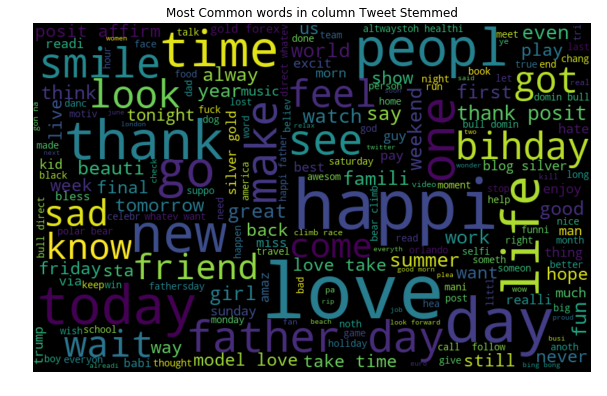

In [40]:
#visualizing all the words in column "tweet_stemmed" in our data using the wordcloud plot.
all_words = ' '.join([text for text in combine_df['tweet_stemmed']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Most Common words in column Tweet Stemmed")
plt.show()

### Extracting Features from Cleaned Tweets¶

In [41]:
# Importing library
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
bow_vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9, max_features=1000, min_df=2,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [42]:
# bag-of-words feature matrix - For columns "combine_df['tweet_stemmed']"
bow_stem = bow_vectorizer.fit_transform(combine_df['tweet_stemmed'])
bow_stem

<49159x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 203386 stored elements in Compressed Sparse Row format>

In [43]:
# bag-of-words feature matrix - For column - combine_df['tweet_lemmatized']
bow_lemm = bow_vectorizer.fit_transform(combine_df['tweet_lemmatized'])
bow_lemm

<49159x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 187343 stored elements in Compressed Sparse Row format>

### B - TF-IDF Features

In [44]:
# Importing library
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
tfidf_vectorizer

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9, max_features=1000, min_df=2,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

### B.1 TF-IDF feature matrix - For columns "combine_df['tweet_stemmed']"

In [45]:
# TF-IDF feature matrix - For columns "combine_df['tweet_stemmed']"
tfidf_stem = tfidf_vectorizer.fit_transform(combine_df['tweet_stemmed'])
tfidf_stem

<49159x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 203386 stored elements in Compressed Sparse Row format>

### B.2 TF-IDF feature matrix - For columns "combine_df['tweet_lemmatized']"

In [46]:
# TF-IDF feature matrix - For columns "combine_df['tweet_lemmatized']"
tfidf_lemm = tfidf_vectorizer.fit_transform(combine_df['tweet_lemmatized'])
tfidf_lemm

<49159x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 187343 stored elements in Compressed Sparse Row format>

### Logistic Regression Model Building: Twitter Sentiment Analysis

In [47]:
# Importing Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

### A Building model using Bag-of-Words features¶

In [60]:
# A.1 For columns "combine_df['tweet_stemmed']"
train_bow = bow_stem[:31962,:]
test_bow = bow_stem[31962:,:]

# splitting data into training and validation set
xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(train_bow, train_df['label'], random_state=42, test_size=0.3)

lreg = LogisticRegression()
lreg.fit(xtrain_bow, ytrain) # training the model

prediction = lreg.predict_proba(xvalid_bow) # predicting on the validation set
prediction_int = prediction[:,1] >= 0.3 # if prediction is greater than or equal to 0.3 than 1 else 0
prediction_int = prediction_int.astype(np.int)

A1 = f1_score(yvalid, prediction_int)*100 # calculating f1 score
print(A1)

55.509527754763866


In [61]:
# A.2 For columns "combine_df['tweet_lemmatized']"
train_bow = bow_lemm[:31962,:]
test_bow = bow_lemm[31962:,:]

# splitting data into training and validation set
xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(train_bow, train_df['label'], random_state=42, test_size=0.3)

lreg = LogisticRegression()
lreg.fit(xtrain_bow, ytrain) # training the model

prediction = lreg.predict_proba(xvalid_bow) # predicting on the validation set
prediction_int = prediction[:,1] >= 0.3 # if prediction is greater than or equal to 0.3 than 1 else 0
prediction_int = prediction_int.astype(np.int)

A2 = f1_score(yvalid, prediction_int)*100 # calculating f1 score
print(A2)

53.72112917023097


### B Building model using TF-IDF features¶

In [62]:
# B.1 For columns "combine_df['tweet_stemmed']"
train_tfidf = tfidf_stem[:31962,:]
test_tfidf = tfidf_stem[31962:,:]

xtrain_tfidf = train_tfidf[ytrain.index]
xvalid_tfidf = train_tfidf[yvalid.index]

lreg.fit(xtrain_tfidf, ytrain)

prediction = lreg.predict_proba(xvalid_tfidf)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)

B1 = f1_score(yvalid, prediction_int)*100 # calculating f1 score
print(B1)

54.44933920704845


In [63]:
# B.2 For columns "combine_df['tweet_lemmatized']"
train_tfidf = tfidf_lemm[:31962,:]
test_tfidf = tfidf_lemm[31962:,:]

xtrain_tfidf = train_tfidf[ytrain.index]
xvalid_tfidf = train_tfidf[yvalid.index]

lreg.fit(xtrain_tfidf, ytrain)

prediction = lreg.predict_proba(xvalid_tfidf)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)

B2 = f1_score(yvalid, prediction_int)*100 # calculating f1 score
print(B2)

53.75


In [64]:
print("\nF1 - Score Chart\n")
print("F1-Score - Model using Bag-of-Words features")
print(" F1-Score = ",A1," - For column tweets are stemmed")
print(" F1-Score = ",A2," - For column tweets are Lemmatized\n\n")
print("F1-Score - Model using TF-IDF features")
print(" F1-Score = ",B1," - For column tweets are stemmed")
print(" F1-Score = ",B2," - For column tweets are Lemmatized")


F1 - Score Chart

F1-Score - Model using Bag-of-Words features
 F1-Score =  55.509527754763866  - For column tweets are stemmed
 F1-Score =  53.72112917023097  - For column tweets are Lemmatized


F1-Score - Model using TF-IDF features
 F1-Score =  54.44933920704845  - For column tweets are stemmed
 F1-Score =  53.75  - For column tweets are Lemmatized
